In [1]:
import snapatac2 as snap
import pandas as pd
import numpy as np 
import polars as pl 
import os
import scanpy as sc

In [ ]:
## ADD reference to agg data 

In [12]:
t = snap.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/FINAL_AGG_ATAC/intermediate_final_snap_data_UMAP.h5ad")

In [13]:
t

AnnData object with n_obs x n_vars = 25088 x 6062095 backed at '/scratch/fatemeh.nasrabadi/importsnt/STORAGE/FINAL_AGG_ATAC/intermediate_final_snap_data_UMAP.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'site', 'patient', 'patientzone', 'celltype_from_atac', 'source', 'Bigannotation', 'celltype_edited_Tuomr', 'leiden'
    var: 'count', 'selected'
    uns: 'patientzone_colors', 'Bigannotation_colors', 'spectral_eigenvalue', 'celltype_from_atac_colors', 'celltype_edited_Tuomr_colors'
    obsm: 'X_spectral', 'fragment_paired', 'X_spectral_harmony', 'X_spectral_mnn', 'X_umap'
    obsp: 'distances'

In [14]:
core =snap.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_snap.h5ad")

In [15]:
core

AnnData object with n_obs x n_vars = 3105 x 6062095 backed at '/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_snap.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype_from_atac', 'site', 'patient', 'patientzone'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'scrublet_sim_doublet_score', 'spectral_eigenvalue', 'doublet_rate', 'frag_size_distr'
    obsm: 'X_spectral', 'X_umap', 'fragment_paired'
    obsp: 'distances'

In [16]:
 t.uns['reference_sequences'] = core.uns['reference_sequences'] 

/tmp/ipykernel_2658073/1196389703.py:1: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  t.uns['reference_sequences'] = core.uns['reference_sequences']
/tmp/ipykernel_2658073/1196389703.py:1: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  t.uns['reference_sequences'] = core.uns['reference_sequences']


In [17]:
t.close()

In [18]:
core.close()

# Core1 ,

In [59]:
import scanpy as sc

# Define the sample-specific parameters for BTROHT01_Core
sample_info = {
    "BTROHT01_Core": ("Core", "BTROHT01", "BTROHT01_Core")
}

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT01_7_core_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap_Tumors.h5ad"

# Load the data
gene_matrix = sc.read(gene_matrix_path)
snap_data = sc.read(snap_path)

# Step 1: Filter tumor cells and create a new AnnData object for tumor cells
def filter_tumor_cells(snap_data, gene_matrix):
    """
    Filter the AnnData object to include only tumor cells.
    
    Arguments:
    - snap_data: The original AnnData object.
    - gene_matrix: The AnnData object containing the gene expression data.
    
    Returns:
    - New AnnData object containing only tumor cells.
    """
    # Extract tumor barcodes from gene_matrix where celltype is 'Tumor cells'
    tumor_barcodes = gene_matrix.obs[gene_matrix.obs["celltype"] == "Tumor cells"].index
    
    # Filter the snap_data to keep only the tumor barcodes
    snap_atac_data_tumor = snap_data[snap_data.obs_names.isin(tumor_barcodes), :]
    
    return snap_atac_data_tumor

# Create the tumor-only AnnData object
tumor_data = filter_tumor_cells(snap_data, gene_matrix)

# Step 2: Save the filtered tumor data to the specified output path
tumor_data.write(output_tumor_path)
print(f"Filtered tumor data saved to {output_tumor_path}")

# Step 3: Add suffix to both the original AnnData and tumor data
def rename_barcodes(adata, suffix):
    """
    Renames the barcodes in an AnnData object by adding a suffix.
    
    Arguments:
    - adata: AnnData object
    - suffix: The suffix to append to the barcode names
    
    Returns:
    - A new AnnData object with renamed barcodes
    """
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

# Apply the renaming of barcodes with suffix to both datasets
snap_data_with_suffix = rename_barcodes(snap_data, "BTROHT01_Core")
tumor_data_with_suffix = rename_barcodes(tumor_data, "BTROHT01_Core")

# Step 4: Add site, patient, and patientzone as `obs` columns for both datasets
def add_obs_columns(adata, sample_info, suffix):
    """
    Add site, patient, and patientzone to the obs of the AnnData object.
    
    Arguments:
    - adata: The AnnData object to update.
    - sample_info: Dictionary containing sample info (site, patient, zone).
    - suffix: Suffix to determine the sample information.
    
    Returns:
    - Updated AnnData object with new `obs` columns.
    """
    site, patient, zone = sample_info[suffix]
    adata.obs["site"] = site
    adata.obs["patient"] = patient
    adata.obs["patientzone"] = f"{zone}"
    return adata

# Add the `obs` columns to both the full data and tumor data
snap_data_with_obs = add_obs_columns(snap_data_with_suffix, sample_info, "BTROHT01_Core")
tumor_data_with_obs = add_obs_columns(tumor_data_with_suffix, sample_info, "BTROHT01_Core")

# Step 5: Save both the updated full data and tumor data to their respective paths
snap_data_with_obs.write(snap_path)
tumor_data_with_obs.write(output_tumor_path)

print(f"Updated original data saved to {snap_path}")
print(f"Updated tumor data saved to {output_tumor_path}")


Filtered tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap_Tumors.h5ad


... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical
... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical


Updated original data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad
Updated tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap_Tumors.h5ad


In [103]:
def rename_barcodes(adata, suffix):
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

In [104]:
core1_matrix = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT01_7_core_gene_matrix_ANNOTATED_FINAL.h5ad")

In [105]:
core1_matrix = rename_barcodes(core1_matrix, "BTROHT01_Core")

In [106]:
core1 = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad")

In [111]:
core1.obs["celltype_from_atac"] = core1_matrix.obs['celltype']

In [113]:
core1.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad")

In [112]:
core1.obs["celltype_from_atac"].value_counts()

celltype_from_atac
Tumor cells     364
Immune Cells     82
Name: count, dtype: int64

In [60]:
tumor_core1 = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap_Tumors.h5ad")

In [61]:
tumor_core1

AnnData object with n_obs × n_vars = 364 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'site', 'patient', 'patientzone'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [62]:
tumor_core1.obs.index

Index(['AAACGGATCATTGCAA-1_BTROHT01_Core', 'AAACGGATCTCAATTC-1_BTROHT01_Core',
       'AAAGCGGGTCATGCAA-1_BTROHT01_Core', 'AAAGCTTGTCACTCGC-1_BTROHT01_Core',
       'AAAGCTTGTTAGGATT-1_BTROHT01_Core', 'AAAGCTTGTTGTTCAC-1_BTROHT01_Core',
       'AAATGGCCACAACCTA-1_BTROHT01_Core', 'AACCTCACACTCGCTC-1_BTROHT01_Core',
       'AACCTTGCAGGCTTGT-1_BTROHT01_Core', 'AACGACAAGGTATTGC-1_BTROHT01_Core',
       ...
       'TTGTCCATCATTACAG-1_BTROHT01_Core', 'TTGTCCGGTCGAAGTC-1_BTROHT01_Core',
       'TTTAACGAGAGGGACT-1_BTROHT01_Core', 'TTTAAGGTCCCATAGG-1_BTROHT01_Core',
       'TTTCATCAGCTCCTTA-1_BTROHT01_Core', 'TTTGACCGTCCTTTAA-1_BTROHT01_Core',
       'TTTGCGGAGCCAGTAT-1_BTROHT01_Core', 'TTTGGTGCACACAATT-1_BTROHT01_Core',
       'TTTGTGGCAAGTCGCT-1_BTROHT01_Core', 'TTTGTTGGTGCTAGAC-1_BTROHT01_Core'],
      dtype='object', name='index', length=364)

In [63]:
Snap_core1 = sc.read('/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad' )

In [70]:
Snap_core1.write('/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad' )

In [64]:
Snap_core1.obs.index

Index(['AAACGGATCATTGCAA-1_BTROHT01_Core', 'AAACGGATCTCAATTC-1_BTROHT01_Core',
       'AAAGCGGGTCATGCAA-1_BTROHT01_Core', 'AAAGCTTGTCACTCGC-1_BTROHT01_Core',
       'AAAGCTTGTTAGGATT-1_BTROHT01_Core', 'AAAGCTTGTTGTTCAC-1_BTROHT01_Core',
       'AAATGGCCACAACCTA-1_BTROHT01_Core', 'AACCTCACACTCGCTC-1_BTROHT01_Core',
       'AACCTTGCAGGCTTGT-1_BTROHT01_Core', 'AACGACAAGGTATTGC-1_BTROHT01_Core',
       ...
       'TTGTCCGGTCGAAGTC-1_BTROHT01_Core', 'TTTAACGAGAGGGACT-1_BTROHT01_Core',
       'TTTAAGGTCCCATAGG-1_BTROHT01_Core', 'TTTCATCAGCTCCTTA-1_BTROHT01_Core',
       'TTTGACCGTCCTTTAA-1_BTROHT01_Core', 'TTTGCGGAGCCAGTAT-1_BTROHT01_Core',
       'TTTGGTGCACACAATT-1_BTROHT01_Core', 'TTTGTCTAGGACGTAA-1_BTROHT01_Core',
       'TTTGTGGCAAGTCGCT-1_BTROHT01_Core', 'TTTGTTGGTGCTAGAC-1_BTROHT01_Core'],
      dtype='object', name='index', length=446)

In [65]:
Snap_core1

AnnData object with n_obs × n_vars = 446 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'site', 'patient', 'patientzone'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [ ]:
# read and check gene matrics 

In [66]:
core1_matrix = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT01_7_core_gene_matrix_ANNOTATED_FINAL.h5ad")

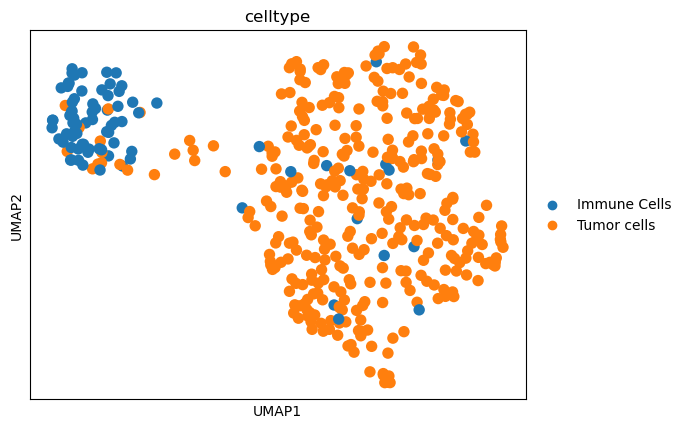

In [67]:
sc.pl.umap(core1_matrix, color ='celltype' )

In [3]:
## Finalized check _ the indexes and snap all and tumor file 

import scanpy as sc

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT01_7_core_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap_Tumors.h5ad"

# 1. Read the snap data
snap_data = sc.read(snap_path)

# Print snap data information
print("Snap Data Information:")
print(snap_data)

# Print value counts of "celltype_from_atac" in obs
print("\nValue counts for 'celltype_from_atac':")
print(snap_data.obs["celltype_from_atac"].value_counts())

# Print indexes of snap data
print("\nIndexes of Snap Data (obs_names):")
print(snap_data.obs_names)

# 2. Read the tumor snap data
tumor_data = sc.read(output_tumor_path)

# Print tumor data information
print("\nTumor Data Information:")
print(tumor_data)

# Print indexes of tumor snap data
print("\nIndexes of Tumor Data (obs_names):")
print(tumor_data.obs_names)


Snap Data Information:
AnnData object with n_obs × n_vars = 446 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'site', 'patient', 'patientzone', 'celltype_from_atac'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

Value counts for 'celltype_from_atac':
celltype_from_atac
Tumor cells     364
Immune Cells     82
Name: count, dtype: int64

Indexes of Snap Data (obs_names):
Index(['AAACGGATCATTGCAA-1_BTROHT01_Core', 'AAACGGATCTCAATTC-1_BTROHT01_Core',
       'AAAGCGGGTCATGCAA-1_BTROHT01_Core', 'AAAGCTTGTCACTCGC-1_BTROHT01_Core',
       'AAAGCTTGTTAGGATT-1_BTROHT01_Core', 'AAAGCTTGTTGTTCAC-1_BTROHT01_Core',
       'AAATGGCCACAACCTA-1_BTROHT01_Core', 'AACCTCACACTCGCTC-1_BTROHT01_Core',
       'AACCTTGCAGGCTTGT-1_BTROHT01_Core', 'AACGACAAGGTATTGC-1_BTROHT01_Core',
       ...
       'TTGTCCGGTCGAAGTC-1_BTROHT01_Core', 'TTTAACGAGAGGGACT-1_BTROHT01_Core',
       'TTTAAGGTCCCATAGG-1_BTROHT01_Core', 'TTTCATCAGCTCCTTA-1_BTROHT01_Core',
       'TTTGACCGTCCTTTAA-1_BTROHT01_Core

# Peri1 

In [71]:
import scanpy as sc

# Define the sample-specific parameters for BTROHT01_Core
sample_info = {
    "BTROHT01_Peri": ("Peri", "BTROHT01", "BTROHT01_Peri")
}

# Paths for the gene matrix and Snap data
gene_matrix_path = "/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Perimarginal/BTROHT01_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_peri_snap_Tumors.h5ad"

# Load the data
gene_matrix = sc.read(gene_matrix_path)
snap_data = sc.read(snap_path)

# Step 1: Filter tumor cells and create a new AnnData object for tumor cells
def filter_tumor_cells(snap_data, gene_matrix):
    """
    Filter the AnnData object to include only tumor cells.
    
    Arguments:
    - snap_data: The original AnnData object.
    - gene_matrix: The AnnData object containing the gene expression data.
    
    Returns:
    - New AnnData object containing only tumor cells.
    """
    # Extract tumor barcodes from gene_matrix where celltype is 'Tumor cells'
    tumor_barcodes = gene_matrix.obs[gene_matrix.obs["celltype"] == "Tumor cells"].index
    
    # Filter the snap_data to keep only the tumor barcodes
    snap_atac_data_tumor = snap_data[snap_data.obs_names.isin(tumor_barcodes), :]
    
    return snap_atac_data_tumor

# Create the tumor-only AnnData object
tumor_data = filter_tumor_cells(snap_data, gene_matrix)

# Step 2: Save the filtered tumor data to the specified output path
tumor_data.write(output_tumor_path)
print(f"Filtered tumor data saved to {output_tumor_path}")

# Step 3: Add suffix to both the original AnnData and tumor data
def rename_barcodes(adata, suffix):
    """
    Renames the barcodes in an AnnData object by adding a suffix.
    
    Arguments:
    - adata: AnnData object
    - suffix: The suffix to append to the barcode names
    
    Returns:
    - A new AnnData object with renamed barcodes
    """
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

# Apply the renaming of barcodes with suffix to both datasets
snap_data_with_suffix = rename_barcodes(snap_data, "BTROHT01_Peri")
tumor_data_with_suffix = rename_barcodes(tumor_data, "BTROHT01_Peri")

# Step 4: Add site, patient, and patientzone as `obs` columns for both datasets
def add_obs_columns(adata, sample_info, suffix):
    """
    Add site, patient, and patientzone to the obs of the AnnData object.
    
    Arguments:
    - adata: The AnnData object to update.
    - sample_info: Dictionary containing sample info (site, patient, zone).
    - suffix: Suffix to determine the sample information.
    
    Returns:
    - Updated AnnData object with new `obs` columns.
    """
    site, patient, zone = sample_info[suffix]
    adata.obs["site"] = site
    adata.obs["patient"] = patient
    adata.obs["patientzone"] = f"{zone}"
    return adata

# Add the `obs` columns to both the full data and tumor data
snap_data_with_obs = add_obs_columns(snap_data_with_suffix, sample_info, "BTROHT01_Peri")
tumor_data_with_obs = add_obs_columns(tumor_data_with_suffix, sample_info, "BTROHT01_Peri")

# Step 5: Save both the updated full data and tumor data to their respective paths
snap_data_with_obs.write(snap_path)
tumor_data_with_obs.write(output_tumor_path)

print(f"Updated original data saved to {snap_path}")
print(f"Updated tumor data saved to {output_tumor_path}")


Filtered tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_peri_snap_Tumors.h5ad


... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical
... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical


Updated original data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad
Updated tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_peri_snap_Tumors.h5ad


In [116]:
matrix = sc.read("/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Perimarginal/BTROHT01_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad")

In [117]:
def rename_barcodes(adata, suffix):

    adata = adata.copy()

    adata.obs_names = adata.obs_names + f"_{suffix}"

    return adata


matrix = sc.read("/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Perimarginal/BTROHT01_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad")

matrix = rename_barcodes(matrix, "BTROHT01_Peri")

allda = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad")

allda.obs["celltype_from_atac"] = matrix.obs['celltype']

allda.obs["celltype_from_atac"].value_counts()

#allda.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad")

In [118]:
matrix = rename_barcodes(matrix, "BTROHT01_Peri")

In [119]:
allda = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad")


In [120]:
allda

AnnData object with n_obs × n_vars = 3123 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'site', 'patient', 'patientzone'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [121]:
allda.obs["celltype_from_atac"] = matrix.obs['celltype']

In [122]:
allda.obs["celltype_from_atac"].value_counts()

celltype_from_atac
Oligodendrocytes    1220
Neurons              709
Immune Cells         538
Tumor cells          227
IN-SST                96
IN-PVALB              88
IN-VIP                47
IN-LAMP5              45
Astrocytes            34
Name: count, dtype: int64

In [123]:
allda.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad")

In [ ]:
def rename_barcodes(adata, suffix):

    adata = adata.copy()

    adata.obs_names = adata.obs_names + f"_{suffix}"

    return adata

core1_matrix = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT01_7_core_gene_matrix_ANNOTATED_FINAL.h5ad")

core1_matrix = rename_barcodes(core1_matrix, "BTROHT01_Core")

core1 = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad")

core1.obs["celltype_from_atac"] = core1_matrix.obs['celltype']

core1.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad")

core1.obs["celltype_from_atac"].value_counts()

celltype_from_atac
Tumor cells     364
Immune Cells     82
Name: count, dtype: int64

In [38]:
peri_matrix = sc.read("/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Perimarginal/BTROHT01_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad")

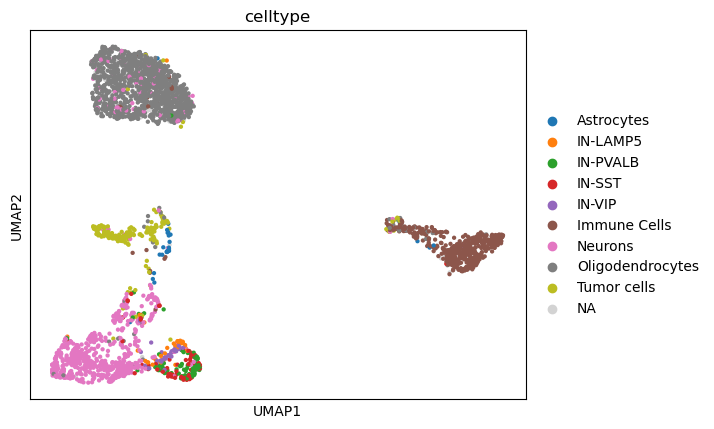

In [41]:
sc.pl.umap(peri_matrix , color = "celltype")

In [78]:
Snap_peri1 = sc.read('/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad' )

In [80]:
Snap_peri1.obs.index

Index(['AAACAGCCAATGCCCG-1_BTROHT01_Peri', 'AAACAGCCATAAGGAC-1_BTROHT01_Peri',
       'AAACATGCAGAACCGA-1_BTROHT01_Peri', 'AAACATGCAGCATTAT-1_BTROHT01_Peri',
       'AAACATGCAGGATGGC-1_BTROHT01_Peri', 'AAACCAACAGCAAATA-1_BTROHT01_Peri',
       'AAACCGAAGCTATTAG-1_BTROHT01_Peri', 'AAACCGCGTCATAACG-1_BTROHT01_Peri',
       'AAACCGCGTTACGCGG-1_BTROHT01_Peri', 'AAACCGGCAGCAATAA-1_BTROHT01_Peri',
       ...
       'TTTGTGGCACCTAAGC-1_BTROHT01_Peri', 'TTTGTGGCAGCCAGAA-1_BTROHT01_Peri',
       'TTTGTGGCATGAATAG-1_BTROHT01_Peri', 'TTTGTGTTCAAACTCA-1_BTROHT01_Peri',
       'TTTGTGTTCAAGGACA-1_BTROHT01_Peri', 'TTTGTGTTCCGTCCAT-1_BTROHT01_Peri',
       'TTTGTGTTCGTTCACC-1_BTROHT01_Peri', 'TTTGTTGGTAACGGGA-1_BTROHT01_Peri',
       'TTTGTTGGTTAACGGC-1_BTROHT01_Peri', 'TTTGTTGGTTACATCC-1_BTROHT01_Peri'],
      dtype='object', name='index', length=3123)

In [81]:
tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_peri_snap_Tumors.h5ad")

In [82]:
tumor 

AnnData object with n_obs × n_vars = 227 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'site', 'patient', 'patientzone'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [4]:
## Finalized check the indexed and snap all and tumor file 

import scanpy as sc

# Paths for the gene matrix and Snap data
gene_matrix_path = "/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Perimarginal/BTROHT01_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_peri_snap_Tumors.h5ad"

# 1. Read the snap data
snap_data = sc.read(snap_path)

# Print snap data information
print("Snap Data Information:")
print(snap_data)

# Print value counts of "celltype_from_atac" in obs
print("\nValue counts for 'celltype_from_atac':")
print(snap_data.obs["celltype_from_atac"].value_counts())

# Print indexes of snap data
print("\nIndexes of Snap Data (obs_names):")
print(snap_data.obs_names)

# 2. Read the tumor snap data
tumor_data = sc.read(output_tumor_path)

# Print tumor data information
print("\nTumor Data Information:")
print(tumor_data)

# Print indexes of tumor snap data
print("\nIndexes of Tumor Data (obs_names):")
print(tumor_data.obs_names)


Snap Data Information:
AnnData object with n_obs × n_vars = 3123 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'site', 'patient', 'patientzone', 'celltype_from_atac'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

Value counts for 'celltype_from_atac':
celltype_from_atac
Oligodendrocytes    1220
Neurons              709
Immune Cells         538
Tumor cells          227
IN-SST                96
IN-PVALB              88
IN-VIP                47
IN-LAMP5              45
Astrocytes            34
Name: count, dtype: int64

Indexes of Snap Data (obs_names):
Index(['AAACAGCCAATGCCCG-1_BTROHT01_Peri', 'AAACAGCCATAAGGAC-1_BTROHT01_Peri',
       'AAACATGCAGAACCGA-1_BTROHT01_Peri', 'AAACATGCAGCATTAT-1_BTROHT01_Peri',
       'AAACATGCAGGATGGC-1_BTROHT01_Peri', 'AAACCAACAGCAAATA-1_BTROHT01_Peri',
       'AAACCGAAGCTATTAG-1_BTROHT01_Peri', 'AAACCGCGTCATAACG-1_BTROHT01_Peri',
       'AAACCGCGTTACGCGG-1_BTROHT01_Peri', 'AAACCGGCAGCAATAA-1_BTROHT01_Peri',
       ...
       'TTTG

# Core2

In [83]:
import scanpy as sc

# Define the sample-specific parameters for BTROHT01_Core
sample_info = {
    "BTROHT02_Core": ("Core", "BTROHT02", "BTROHT02_Core")
}

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT2_core_snap_Tumors.h5ad"

# Load the data
gene_matrix = sc.read(gene_matrix_path)
snap_data = sc.read(snap_path)

# Step 1: Filter tumor cells and create a new AnnData object for tumor cells
def filter_tumor_cells(snap_data, gene_matrix):
    """
    Filter the AnnData object to include only tumor cells.
    
    Arguments:
    - snap_data: The original AnnData object.
    - gene_matrix: The AnnData object containing the gene expression data.
    
    Returns:
    - New AnnData object containing only tumor cells.
    """
    # Extract tumor barcodes from gene_matrix where celltype is 'Tumor cells'
    tumor_barcodes = gene_matrix.obs[gene_matrix.obs["celltype"] == "Tumor cells"].index
    
    # Filter the snap_data to keep only the tumor barcodes
    snap_atac_data_tumor = snap_data[snap_data.obs_names.isin(tumor_barcodes), :]
    
    return snap_atac_data_tumor

# Create the tumor-only AnnData object
tumor_data = filter_tumor_cells(snap_data, gene_matrix)

# Step 2: Save the filtered tumor data to the specified output path
tumor_data.write(output_tumor_path)
print(f"Filtered tumor data saved to {output_tumor_path}")

# Step 3: Add suffix to both the original AnnData and tumor data
def rename_barcodes(adata, suffix):
    """
    Renames the barcodes in an AnnData object by adding a suffix.
    
    Arguments:
    - adata: AnnData object
    - suffix: The suffix to append to the barcode names
    
    Returns:
    - A new AnnData object with renamed barcodes
    """
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

# Apply the renaming of barcodes with suffix to both datasets
snap_data_with_suffix = rename_barcodes(snap_data, "BTROHT02_Core")
tumor_data_with_suffix = rename_barcodes(tumor_data, "BTROHT02_Core")

# Step 4: Add site, patient, and patientzone as `obs` columns for both datasets
def add_obs_columns(adata, sample_info, suffix):
    """
    Add site, patient, and patientzone to the obs of the AnnData object.
    
    Arguments:
    - adata: The AnnData object to update.
    - sample_info: Dictionary containing sample info (site, patient, zone).
    - suffix: Suffix to determine the sample information.
    
    Returns:
    - Updated AnnData object with new `obs` columns.
    """
    site, patient, zone = sample_info[suffix]
    adata.obs["site"] = site
    adata.obs["patient"] = patient
    adata.obs["patientzone"] = f"{zone}"
    return adata

# Add the `obs` columns to both the full data and tumor data
snap_data_with_obs = add_obs_columns(snap_data_with_suffix, sample_info, "BTROHT02_Core")
tumor_data_with_obs = add_obs_columns(tumor_data_with_suffix, sample_info, "BTROHT02_Core")

# Step 5: Save both the updated full data and tumor data to their respective paths
snap_data_with_obs.write(snap_path)
tumor_data_with_obs.write(output_tumor_path)

print(f"Updated original data saved to {snap_path}")
print(f"Updated tumor data saved to {output_tumor_path}")


Filtered tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT1_core_snap_Tumors.h5ad


... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical
... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical


Updated original data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad
Updated tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT1_core_snap_Tumors.h5ad


In [125]:
def rename_barcodes(adata, suffix):

    adata = adata.copy()

    adata.obs_names = adata.obs_names + f"_{suffix}"

    return adata


matrix = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad")

matrix = rename_barcodes(matrix, "BTROHT02_Core")

allda = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad")

allda.obs["celltype_from_atac"] = matrix.obs['celltype']

allda.obs["celltype_from_atac"].value_counts()

#allda.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad")

celltype_from_atac
Tumor cells     1076
Immune Cells      87
Name: count, dtype: int64

In [126]:
allda.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad")

In [84]:
Snap_core2 = sc.read('/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad' )

In [85]:
Snap_core2

AnnData object with n_obs × n_vars = 1222 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'site', 'patient', 'patientzone'
    var: 'count', 'selected'
    uns: 'TSS_profile', 'doublet_rate', 'frac_overlap_TSS', 'frag_size_distr', 'library_tsse', 'reference_sequences', 'scrublet_sim_doublet_score'
    obsm: 'fragment_paired'

In [86]:
gene_matrics = sc.read("/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Core/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad")

In [87]:
gene_matrics

AnnData object with n_obs × n_vars = 1222 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH04-Core', 'UMAP of ATAC in BTROH02-Core'
    uns: 'UMAP of ATAC in BTROH02-Core_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

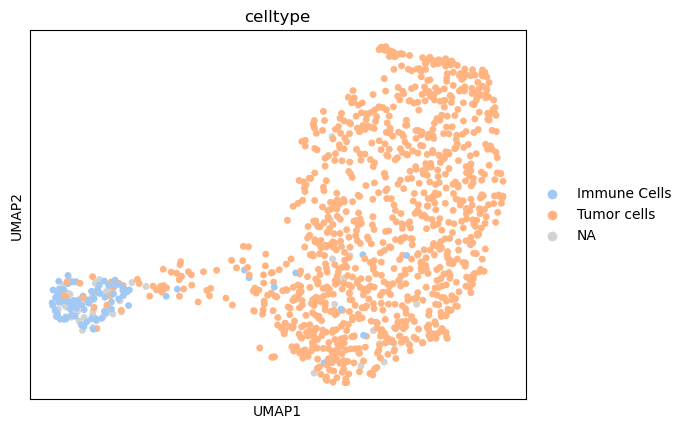

In [47]:
sc.pl.umap(gene_matrics, color = 'celltype' )

In [88]:
tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT1_core_snap_Tumors.h5ad")

In [89]:
tumor

AnnData object with n_obs × n_vars = 1076 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'site', 'patient', 'patientzone'
    var: 'count', 'selected'
    uns: 'TSS_profile', 'doublet_rate', 'frac_overlap_TSS', 'frag_size_distr', 'library_tsse', 'reference_sequences', 'scrublet_sim_doublet_score'
    obsm: 'fragment_paired'

In [5]:
## Finalized check the indexed and snap all and tumor file 

import scanpy as sc

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_7_core_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT2_core_snap_Tumors.h5ad"

# 1. Read the snap data
snap_data = sc.read(snap_path)

# Print snap data information
print("Snap Data Information:")
print(snap_data)

# Print value counts of "celltype_from_atac" in obs
print("\nValue counts for 'celltype_from_atac':")
print(snap_data.obs["celltype_from_atac"].value_counts())

# Print indexes of snap data
print("\nIndexes of Snap Data (obs_names):")
print(snap_data.obs_names)

# 2. Read the tumor snap data
tumor_data = sc.read(output_tumor_path)

# Print tumor data information
print("\nTumor Data Information:")
print(tumor_data)

# Print indexes of tumor snap data
print("\nIndexes of Tumor Data (obs_names):")
print(tumor_data.obs_names)


Snap Data Information:
AnnData object with n_obs × n_vars = 1222 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'site', 'patient', 'patientzone', 'celltype_from_atac'
    var: 'count', 'selected'
    uns: 'TSS_profile', 'doublet_rate', 'frac_overlap_TSS', 'frag_size_distr', 'library_tsse', 'reference_sequences', 'scrublet_sim_doublet_score'
    obsm: 'fragment_paired'

Value counts for 'celltype_from_atac':
celltype_from_atac
Tumor cells     1076
Immune Cells      87
Name: count, dtype: int64

Indexes of Snap Data (obs_names):
Index(['AAACAGCCAGGCGAGT-1_BTROHT02_Core', 'AAACCGGCATCACAGC-1_BTROHT02_Core',
       'AAACGCGCACCTAATG-1_BTROHT02_Core', 'AAACGGATCGGGACCT-1_BTROHT02_Core',
       'AAACGTACACGTGCTG-1_BTROHT02_Core', 'AAAGCAAGTACTTAGG-1_BTROHT02_Core',
       'AAAGCAAGTTCATCTA-1_BTROHT02_Core', 'AAAGCACCATCCCGCT-1_BTROHT02_Core',
       'AAAGCCCGTAGCCTCC-1_BTROHT02_Core', 'AAAGGACGTTCCATTA-1_BTROHT02_Core',
       ...
  

# peri 2 

In [90]:
import scanpy as sc

# Define the sample-specific parameters for BTROHT01_Core
sample_info = {
    "BTROHT02_Peri": ("Peri", "BTROHT02", "BTROHT02_Peri")
}

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT02_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT_02_perimarginal_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT2_peri_snap_Tumors.h5ad"

# Load the data
gene_matrix = sc.read(gene_matrix_path)
snap_data = sc.read(snap_path)

# Step 1: Filter tumor cells and create a new AnnData object for tumor cells
def filter_tumor_cells(snap_data, gene_matrix):
    """
    Filter the AnnData object to include only tumor cells.
    
    Arguments:
    - snap_data: The original AnnData object.
    - gene_matrix: The AnnData object containing the gene expression data.
    
    Returns:
    - New AnnData object containing only tumor cells.
    """
    # Extract tumor barcodes from gene_matrix where celltype is 'Tumor cells'
    tumor_barcodes = gene_matrix.obs[gene_matrix.obs["celltype"] == "Tumor cells"].index
    
    # Filter the snap_data to keep only the tumor barcodes
    snap_atac_data_tumor = snap_data[snap_data.obs_names.isin(tumor_barcodes), :]
    
    return snap_atac_data_tumor

# Create the tumor-only AnnData object
tumor_data = filter_tumor_cells(snap_data, gene_matrix)

# Step 2: Save the filtered tumor data to the specified output path
tumor_data.write(output_tumor_path)
print(f"Filtered tumor data saved to {output_tumor_path}")

# Step 3: Add suffix to both the original AnnData and tumor data
def rename_barcodes(adata, suffix):
    """
    Renames the barcodes in an AnnData object by adding a suffix.
    
    Arguments:
    - adata: AnnData object
    - suffix: The suffix to append to the barcode names
    
    Returns:
    - A new AnnData object with renamed barcodes
    """
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

# Apply the renaming of barcodes with suffix to both datasets
snap_data_with_suffix = rename_barcodes(snap_data, "BTROHT02_Peri")
tumor_data_with_suffix = rename_barcodes(tumor_data, "BTROHT02_Peri")

# Step 4: Add site, patient, and patientzone as `obs` columns for both datasets
def add_obs_columns(adata, sample_info, suffix):
    """
    Add site, patient, and patientzone to the obs of the AnnData object.
    
    Arguments:
    - adata: The AnnData object to update.
    - sample_info: Dictionary containing sample info (site, patient, zone).
    - suffix: Suffix to determine the sample information.
    
    Returns:
    - Updated AnnData object with new `obs` columns.
    """
    site, patient, zone = sample_info[suffix]
    adata.obs["site"] = site
    adata.obs["patient"] = patient
    adata.obs["patientzone"] = f"{zone}"
    return adata

# Add the `obs` columns to both the full data and tumor data
snap_data_with_obs = add_obs_columns(snap_data_with_suffix, sample_info, "BTROHT02_Peri")
tumor_data_with_obs = add_obs_columns(tumor_data_with_suffix, sample_info, "BTROHT02_Peri")

# Step 5: Save both the updated full data and tumor data to their respective paths
snap_data_with_obs.write(snap_path)
tumor_data_with_obs.write(output_tumor_path)

print(f"Updated original data saved to {snap_path}")
print(f"Updated tumor data saved to {output_tumor_path}")


Filtered tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT1_peri_snap_Tumors.h5ad


... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical
... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical


Updated original data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT_02_perimarginal_snap.h5ad
Updated tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT1_peri_snap_Tumors.h5ad


In [127]:
def rename_barcodes(adata, suffix):

    adata = adata.copy()

    adata.obs_names = adata.obs_names + f"_{suffix}"

    return adata


matrix = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT02_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad")

matrix = rename_barcodes(matrix, "BTROHT02_Peri")

allda = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT_02_perimarginal_snap.h5ad")

allda.obs["celltype_from_atac"] = matrix.obs['celltype']

allda.obs["celltype_from_atac"].value_counts()

#allda.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad")

celltype_from_atac
Oligodendrocytes                   1579
Immune Cells                        972
Tumor cells                         319
Oligodendrocyte Precursor Cells     238
Neurons                              34
Name: count, dtype: int64

In [128]:
allda.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT_02_perimarginal_snap.h5ad")

In [ ]:
##Ceck 

In [48]:
gene_matric = sc.read("/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT02/Perimarginal/BTROHT02_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad")

In [148]:
#sc.pl.umap(gene_matric, color = 'celltype' ) ##Checked!! 

In [101]:
Snap_peri2 = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT_02_perimarginal_snap.h5ad" )

In [102]:
Snap_peri2

AnnData object with n_obs × n_vars = 3142 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'site', 'patient', 'patientzone'
    var: 'count', 'selected'
    uns: 'TSS_profile', 'frac_overlap_TSS', 'frag_size_distr', 'library_tsse', 'reference_sequences'
    obsm: 'fragment_paired'

In [7]:
## Finalized check _ the indexes and snap all and tumor file 

import scanpy as sc


# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT02_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT_02_perimarginal_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT2_peri_snap_Tumors.h5ad"

# 1. Read the snap data
snap_data = sc.read(snap_path)

# Print snap data information
print("Snap Data Information:")
print(snap_data)

# Print value counts of "celltype_from_atac" in obs
print("\nValue counts for 'celltype_from_atac':")
print(snap_data.obs["celltype_from_atac"].value_counts())

# Print indexes of snap data
print("\nIndexes of Snap Data (obs_names):")
print(snap_data.obs_names)

# 2. Read the tumor snap data
tumor_data = sc.read(output_tumor_path)

# Print tumor data information
print("\nTumor Data Information:")
print(tumor_data)

# Print indexes of tumor snap data
print("\nIndexes of Tumor Data (obs_names):")
print(tumor_data.obs_names)


Snap Data Information:
AnnData object with n_obs × n_vars = 3142 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'site', 'patient', 'patientzone', 'celltype_from_atac'
    var: 'count', 'selected'
    uns: 'TSS_profile', 'frac_overlap_TSS', 'frag_size_distr', 'library_tsse', 'reference_sequences'
    obsm: 'fragment_paired'

Value counts for 'celltype_from_atac':
celltype_from_atac
Oligodendrocytes                   1579
Immune Cells                        972
Tumor cells                         319
Oligodendrocyte Precursor Cells     238
Neurons                              34
Name: count, dtype: int64

Indexes of Snap Data (obs_names):
Index(['AAACATGCAACCCTCC-1_BTROHT02_Peri', 'AAACATGCAGTAAAGC-1_BTROHT02_Peri',
       'AAACCGAAGCGTGCGT-1_BTROHT02_Peri', 'AAACCGGCACAAAGCG-1_BTROHT02_Peri',
       'AAACGCGCAATGAATG-1_BTROHT02_Peri', 'AAACGCGCACAATACT-1_BTROHT02_Peri',
       'AAACGGATCCAACTGG-1_BTROHT02_Peri', 'AAAGCAAGTTCATCTA-1_BTROHT02_Peri',
       'AAAGCCCGTGTT

In [46]:
t = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT02_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad")

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


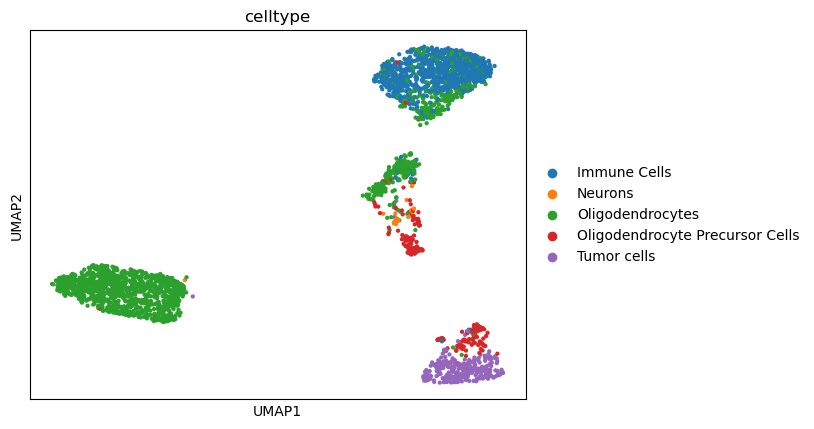

In [48]:
sc.pl.umap(t, color = "celltype")

# Core 3

In [95]:
import scanpy as sc

# Define the sample-specific parameters for BTROHT01_Core
sample_info = {
    "BTROHT03_Core": ("Core", "BTROHT03", "BTROHT03_Core")
}

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_gene_matrix.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT3_core_snap_Tumors.h5ad"

# Load the data
gene_matrix = sc.read(gene_matrix_path)
snap_data = sc.read(snap_path)

# Step 1: Filter tumor cells and create a new AnnData object for tumor cells
def filter_tumor_cells(snap_data, gene_matrix):
    """
    Filter the AnnData object to include only tumor cells.
    
    Arguments:
    - snap_data: The original AnnData object.
    - gene_matrix: The AnnData object containing the gene expression data.
    
    Returns:
    - New AnnData object containing only tumor cells.
    """
    # Extract tumor barcodes from gene_matrix where celltype is 'Tumor cells'
    tumor_barcodes = gene_matrix.obs[gene_matrix.obs["celltype"] == "Tumor cells"].index
    
    # Filter the snap_data to keep only the tumor barcodes
    snap_atac_data_tumor = snap_data[snap_data.obs_names.isin(tumor_barcodes), :]
    
    return snap_atac_data_tumor

# Create the tumor-only AnnData object
tumor_data = filter_tumor_cells(snap_data, gene_matrix)

# Step 2: Save the filtered tumor data to the specified output path
tumor_data.write(output_tumor_path)
print(f"Filtered tumor data saved to {output_tumor_path}")

# Step 3: Add suffix to both the original AnnData and tumor data
def rename_barcodes(adata, suffix):
    """
    Renames the barcodes in an AnnData object by adding a suffix.
    
    Arguments:
    - adata: AnnData object
    - suffix: The suffix to append to the barcode names
    
    Returns:
    - A new AnnData object with renamed barcodes
    """
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

# Apply the renaming of barcodes with suffix to both datasets
snap_data_with_suffix = rename_barcodes(snap_data, "BTROHT03_Core")
tumor_data_with_suffix = rename_barcodes(tumor_data, "BTROHT03_Core")

# Step 4: Add site, patient, and patientzone as `obs` columns for both datasets
def add_obs_columns(adata, sample_info, suffix):
    """
    Add site, patient, and patientzone to the obs of the AnnData object.
    
    Arguments:
    - adata: The AnnData object to update.
    - sample_info: Dictionary containing sample info (site, patient, zone).
    - suffix: Suffix to determine the sample information.
    
    Returns:
    - Updated AnnData object with new `obs` columns.
    """
    site, patient, zone = sample_info[suffix]
    adata.obs["site"] = site
    adata.obs["patient"] = patient
    adata.obs["patientzone"] = f"{zone}"
    return adata

# Add the `obs` columns to both the full data and tumor data
snap_data_with_obs = add_obs_columns(snap_data_with_suffix, sample_info,  "BTROHT03_Core")
tumor_data_with_obs = add_obs_columns(tumor_data_with_suffix, sample_info,  "BTROHT03_Core")

# Step 5: Save both the updated full data and tumor data to their respective paths
snap_data_with_obs.write(snap_path)
tumor_data_with_obs.write(output_tumor_path)

print(f"Updated original data saved to {snap_path}")
print(f"Updated tumor data saved to {output_tumor_path}")


Filtered tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT3_core_snap_Tumors.h5ad


... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical
... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical


Updated original data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_snap.h5ad
Updated tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT3_core_snap_Tumors.h5ad


In [ ]:
# check 

In [130]:
def rename_barcodes(adata, suffix):

    adata = adata.copy()

    adata.obs_names = adata.obs_names + f"_{suffix}"

    return adata


matrix = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_gene_matrix.h5ad")

matrix = rename_barcodes(matrix, "BTROHT03_Core")

allda = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_snap.h5ad")

allda.obs["celltype_from_atac"] = matrix.obs['celltype']

allda.obs["celltype_from_atac"].value_counts()

#allda.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_snap.h5ad")

celltype_from_atac
Tumor cells    2584
Microglia        46
T cells          34
Name: count, dtype: int64

In [131]:
allda.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_snap.h5ad")

In [8]:
## Finalized check _ the indexes and snap all and tumor file 

import scanpy as sc


# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_gene_matrix.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT3_core_snap_Tumors.h5ad"


# 1. Read the snap data
snap_data = sc.read(snap_path)

# Print snap data information
print("Snap Data Information:")
print(snap_data)

# Print value counts of "celltype_from_atac" in obs
print("\nValue counts for 'celltype_from_atac':")
print(snap_data.obs["celltype_from_atac"].value_counts())

# Print indexes of snap data
print("\nIndexes of Snap Data (obs_names):")
print(snap_data.obs_names)

# 2. Read the tumor snap data
tumor_data = sc.read(output_tumor_path)

# Print tumor data information
print("\nTumor Data Information:")
print(tumor_data)

# Print indexes of tumor snap data
print("\nIndexes of Tumor Data (obs_names):")
print(tumor_data.obs_names)



Snap Data Information:
AnnData object with n_obs × n_vars = 2664 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'site', 'patient', 'patientzone', 'celltype_from_atac'
    var: 'count', 'selected'
    uns: 'doublet_rate', 'frag_size_distr', 'reference_sequences', 'scrublet_sim_doublet_score', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap', 'fragment_paired'
    obsp: 'distances'

Value counts for 'celltype_from_atac':
celltype_from_atac
Tumor cells    2584
Microglia        46
T cells          34
Name: count, dtype: int64

Indexes of Snap Data (obs_names):
Index(['AAACAGCCATTATGGT-1_BTROHT03_Core', 'AAACATGCAACACCTA-1_BTROHT03_Core',
       'AAACATGCACGTAAGG-1_BTROHT03_Core', 'AAACATGCAGGCTAAG-1_BTROHT03_Core',
       'AAACATGCATGGCCTG-1_BTROHT03_Core', 'AAACCAACAGCAAGAT-1_BTROHT03_Core',
       'AAACCGAAGAATGACG-1_BTROHT03_Core', 'AAACCGAAGGGCTAAA-1_BTROHT03_Core',
       'AAACCGCGTACGTTTC-1_BTROHT03_Core', 'AA

# peri 3 

In [138]:
import scanpy as sc

# Define the sample-specific parameters for BTROHT02_Peri
sample_info = {
    "BTROHT03_Peri": ("Peri", "BTROHT03", "BTROHT03_Peri")
}

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_perimarginal_gene_matrix.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap_Tumors.h5ad"

# Load the data
gene_matrix = sc.read(gene_matrix_path)
snap_data = sc.read(snap_path)

# Step 1: Add 'celltype' to the snap_data from gene_matrix before modifying barcodes
snap_data.obs["celltype"] = gene_matrix.obs["celltype"]

# Step 2: Filter tumor cells and create a new AnnData object for tumor cells
def filter_tumor_cells(snap_data, gene_matrix):
    """
    Filter the AnnData object to include only tumor cells.
    
    Arguments:
    - snap_data: The original AnnData object.
    - gene_matrix: The AnnData object containing the gene expression data.
    
    Returns:
    - New AnnData object containing only tumor cells.
    """
    # Extract tumor barcodes from gene_matrix where celltype is 'Tumor cells'
    tumor_barcodes = gene_matrix.obs[gene_matrix.obs["celltype"] == "Tumor cells"].index
    
    # Filter the snap_data to keep only the tumor barcodes
    snap_atac_data_tumor = snap_data[snap_data.obs_names.isin(tumor_barcodes), :]
    
    return snap_atac_data_tumor

# Create the tumor-only AnnData object
tumor_data = filter_tumor_cells(snap_data, gene_matrix)

# Step 3: Save the filtered tumor data to the specified output path
tumor_data.write(output_tumor_path)
print(f"Filtered tumor data saved to {output_tumor_path}")

# Step 4: Add suffix to both the original AnnData and tumor data
def rename_barcodes(adata, suffix):
    """
    Renames the barcodes in an AnnData object by adding a suffix.
    
    Arguments:
    - adata: AnnData object
    - suffix: The suffix to append to the barcode names
    
    Returns:
    - A new AnnData object with renamed barcodes
    """
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

# Apply the renaming of barcodes with suffix to both datasets
snap_data_with_suffix = rename_barcodes(snap_data, "BTROHT03_Peri")
tumor_data_with_suffix = rename_barcodes(tumor_data, "BTROHT03_Peri")

# Step 5: Add site, patient, and patientzone as `obs` columns for both datasets
def add_obs_columns(adata, sample_info, suffix):
    """
    Add site, patient, and patientzone to the obs of the AnnData object.
    
    Arguments:
    - adata: The AnnData object to update.
    - sample_info: Dictionary containing sample info (site, patient, zone).
    - suffix: Suffix to determine the sample information.
    
    Returns:
    - Updated AnnData object with new `obs` columns.
    """
    site, patient, zone = sample_info[suffix]
    adata.obs["site"] = site
    adata.obs["patient"] = patient
    adata.obs["patientzone"] = f"{zone}"
    return adata

# Add the `obs` columns to both the full data and tumor data
snap_data_with_obs = add_obs_columns(snap_data_with_suffix, sample_info, "BTROHT03_Peri")
tumor_data_with_obs = add_obs_columns(tumor_data_with_suffix, sample_info, "BTROHT03_Peri")

# Step 6: Save both the updated full data and tumor data to their respective paths
snap_data_with_obs.write(snap_path)  # Save the updated AnnData object
tumor_data_with_obs.write(output_tumor_path)  # Save the tumor data with updated index and obs

print(f"Updated original data saved to {snap_path}")
print(f"Updated tumor data saved to {output_tumor_path}")


Filtered tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap_Tumors.h5ad


... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical
... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical


Updated original data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap.h5ad
Updated tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap_Tumors.h5ad


In [ ]:
#make celltype name universal 

In [149]:
#check 
allda = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap.h5ad")

In [150]:
allda.obs["celltype_from_atac"]=allda.obs["celltype"]

In [143]:
allda.obs["celltype"].value_counts()

celltype
Brain neurons    2352
mOli             1206
Microglia         360
OPCs               52
T cells            14
Tumor cells         6
Astrocytes          3
Name: count, dtype: int64

In [151]:
allda.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap.h5ad")

In [144]:
tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap_Tumors.h5ad")
tumor

AnnData object with n_obs × n_vars = 6 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'celltype', 'site', 'patient', 'patientzone'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [9]:
## Finalized check _ the indexes and snap all and tumor file 

import scanpy as sc


# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_perimarginal_gene_matrix.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap_Tumors.h5ad"


# 1. Read the snap data
snap_data = sc.read(snap_path)

# Print snap data information
print("Snap Data Information:")
print(snap_data)

# Print value counts of "celltype_from_atac" in obs
print("\nValue counts for 'celltype_from_atac':")
print(snap_data.obs["celltype_from_atac"].value_counts())

# Print indexes of snap data
print("\nIndexes of Snap Data (obs_names):")
print(snap_data.obs_names)

# 2. Read the tumor snap data
tumor_data = sc.read(output_tumor_path)

# Print tumor data information
print("\nTumor Data Information:")
print(tumor_data)

# Print indexes of tumor snap data
print("\nIndexes of Tumor Data (obs_names):")
print(tumor_data.obs_names)



Snap Data Information:
AnnData object with n_obs × n_vars = 3993 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'celltype', 'site', 'patient', 'patientzone', 'celltype_from_atac'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

Value counts for 'celltype_from_atac':
celltype_from_atac
Brain neurons    2352
mOli             1206
Microglia         360
OPCs               52
T cells            14
Tumor cells         6
Astrocytes          3
Name: count, dtype: int64

Indexes of Snap Data (obs_names):
Index(['AAACAGCCAAATTCGT-1_BTROHT03_Peri', 'AAACAGCCACTCGCTC-1_BTROHT03_Peri',
       'AAACAGCCAGCAAGAT-1_BTROHT03_Peri', 'AAACAGCCATCAGCAC-1_BTROHT03_Peri',
       'AAACAGCCATTGTCCT-1_BTROHT03_Peri', 'AAACATGCATATAACC-1_BTROHT03_Peri',
       'AAACCAACACAGCCTG-1_BTROHT03_Peri', 'AAACCAACATAAACCT-1_BTROHT03_Peri',
       'AAACCGAAGACAAAGT-1_BTROHT03_Peri', 'AAACCGAAGGTGTTAC-1_BTROHT03_Peri',
       ...
       'TTTGTGGCAAAGCTCC-1_BTROHT03_Peri', 'TTTGTGGCAACCTAAT-1_BTROHT03

# Core 4 

In [147]:
import scanpy as sc

# Define the sample-specific parameters for BTROHT01_Core
sample_info = {
    "BTROHT04_Core": ("Core", "BTROHT04", "BTROHT04_Core")
}

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT04_7_core_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap_Tumors.h5ad"

# Load the data
gene_matrix = sc.read(gene_matrix_path)
snap_data = sc.read(snap_path)

# Step 1: Filter tumor cells and create a new AnnData object for tumor cells
def filter_tumor_cells(snap_data, gene_matrix):
    """
    Filter the AnnData object to include only tumor cells.
    
    Arguments:
    - snap_data: The original AnnData object.
    - gene_matrix: The AnnData object containing the gene expression data.
    
    Returns:
    - New AnnData object containing only tumor cells.
    """
    # Extract tumor barcodes from gene_matrix where celltype is 'Tumor cells'
    tumor_barcodes = gene_matrix.obs[gene_matrix.obs["celltype"] == "Tumor cells"].index
    
    # Filter the snap_data to keep only the tumor barcodes
    snap_atac_data_tumor = snap_data[snap_data.obs_names.isin(tumor_barcodes), :]
    
    return snap_atac_data_tumor

# Create the tumor-only AnnData object
tumor_data = filter_tumor_cells(snap_data, gene_matrix)

# Step 2: Save the filtered tumor data to the specified output path
tumor_data.write(output_tumor_path)
print(f"Filtered tumor data saved to {output_tumor_path}")

# Step 3: Add suffix to both the original AnnData and tumor data
def rename_barcodes(adata, suffix):
    """
    Renames the barcodes in an AnnData object by adding a suffix.
    
    Arguments:
    - adata: AnnData object
    - suffix: The suffix to append to the barcode names
    
    Returns:
    - A new AnnData object with renamed barcodes
    """
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

# Apply the renaming of barcodes with suffix to both datasets
snap_data_with_suffix = rename_barcodes(snap_data, "BTROHT04_Core")
tumor_data_with_suffix = rename_barcodes(tumor_data, "BTROHT04_Core")

# Step 4: Add site, patient, and patientzone as `obs` columns for both datasets
def add_obs_columns(adata, sample_info, suffix):
    """
    Add site, patient, and patientzone to the obs of the AnnData object.
    
    Arguments:
    - adata: The AnnData object to update.
    - sample_info: Dictionary containing sample info (site, patient, zone).
    - suffix: Suffix to determine the sample information.
    
    Returns:
    - Updated AnnData object with new `obs` columns.
    """
    site, patient, zone = sample_info[suffix]
    adata.obs["site"] = site
    adata.obs["patient"] = patient
    adata.obs["patientzone"] = f"{zone}"
    return adata

# Add the `obs` columns to both the full data and tumor data
snap_data_with_obs = add_obs_columns(snap_data_with_suffix, sample_info,  "BTROHT04_Core")
tumor_data_with_obs = add_obs_columns(tumor_data_with_suffix, sample_info,  "BTROHT04_Core")

# Step 5: Save both the updated full data and tumor data to their respective paths
snap_data_with_obs.write(snap_path)
tumor_data_with_obs.write(output_tumor_path)

print(f"Updated original data saved to {snap_path}")
print(f"Updated tumor data saved to {output_tumor_path}")


Filtered tumor data saved to //scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap_Tumors.h5ad


... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical
... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical


Updated original data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap.h5ad
Updated tumor data saved to //scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap_Tumors.h5ad


In [153]:
def rename_barcodes(adata, suffix):

    adata = adata.copy()

    adata.obs_names = adata.obs_names + f"_{suffix}"

    return adata


matrix = sc.read(gene_matrix_path)

matrix = rename_barcodes(matrix, "BTROHT04_Core")

allda = sc.read(snap_path)

allda.obs["celltype_from_atac"] = matrix.obs['celltype']

allda.obs["celltype_from_atac"].value_counts()

#allda.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_snap.h5ad")

celltype_from_atac
InN                 374
Tumor cells         369
Immune Cells        264
L2/3, L2/4          149
L6                  107
L3/5                 88
Oligodendrocytes     59
Astrocytes           49
L5/6                 30
Name: count, dtype: int64

In [154]:
allda.write(snap_path)

In [ ]:
# opc or endo was added to tumor cells in the finalized annotation 

In [10]:
## Finalized check _ the indexes and snap all and tumor file 

import scanpy as sc


# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT04_7_core_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap_Tumors.h5ad"

# 1. Read the snap data
snap_data = sc.read(snap_path)

# Print snap data information
print("Snap Data Information:")
print(snap_data)

# Print value counts of "celltype_from_atac" in obs
print("\nValue counts for 'celltype_from_atac':")
print(snap_data.obs["celltype_from_atac"].value_counts())

# Print indexes of snap data
print("\nIndexes of Snap Data (obs_names):")
print(snap_data.obs_names)

# 2. Read the tumor snap data
tumor_data = sc.read(output_tumor_path)

# Print tumor data information
print("\nTumor Data Information:")
print(tumor_data)

# Print indexes of tumor snap data
print("\nIndexes of Tumor Data (obs_names):")
print(tumor_data.obs_names)



Snap Data Information:
AnnData object with n_obs × n_vars = 1536 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'site', 'patient', 'patientzone', 'celltype_from_atac'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

Value counts for 'celltype_from_atac':
celltype_from_atac
InN                 374
Tumor cells         369
Immune Cells        264
L2/3, L2/4          149
L6                  107
L3/5                 88
Oligodendrocytes     59
Astrocytes           49
L5/6                 30
Name: count, dtype: int64

Indexes of Snap Data (obs_names):
Index(['AAACAGCCAGGATAAC-1_BTROHT04_Core', 'AAACAGCCAGTACCGT-1_BTROHT04_Core',
       'AAACATGCACAACAAA-1_BTROHT04_Core', 'AAACATGCACACAATT-1_BTROHT04_Core',
       'AAACCAACAATGAAGC-1_BTROHT04_Core', 'AAACCGCGTCACCAAA-1_BTROHT04_Core',
       'AAACCGCGTTACTTCA-1_BTROHT04_Core', 'AAACGGATCACAGCGC-1_BTROHT04_Core',
       'AAACGGATCCACCCTG-1_BTROHT04_Core', 'AAACGTACAGGCAAGC-1_BTROHT04_Core',
       ...
       'TTTGACCGTTTGT

# Peri 4 

In [155]:
import scanpy as sc

# Define the sample-specific parameters for BTROHT02_Peri
sample_info = {
    "BTROHT04_Peri": ("Peri", "BTROHT04", "BTROHT04_Peri")
}

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT04_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT_04_perimarginal_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT4_peri_snap_Tumors.h5ad"

# Load the data
gene_matrix = sc.read(gene_matrix_path)
snap_data = sc.read(snap_path)

# Step 1: Add 'celltype' to the snap_data from gene_matrix before modifying barcodes
snap_data.obs["celltype"] = gene_matrix.obs["celltype"]

# Step 2: Filter tumor cells and create a new AnnData object for tumor cells
def filter_tumor_cells(snap_data, gene_matrix):
    """
    Filter the AnnData object to include only tumor cells.
    
    Arguments:
    - snap_data: The original AnnData object.
    - gene_matrix: The AnnData object containing the gene expression data.
    
    Returns:
    - New AnnData object containing only tumor cells.
    """
    # Extract tumor barcodes from gene_matrix where celltype is 'Tumor cells'
    tumor_barcodes = gene_matrix.obs[gene_matrix.obs["celltype"] == "Tumor cells"].index
    
    # Filter the snap_data to keep only the tumor barcodes
    snap_atac_data_tumor = snap_data[snap_data.obs_names.isin(tumor_barcodes), :]
    
    return snap_atac_data_tumor

# Create the tumor-only AnnData object
tumor_data = filter_tumor_cells(snap_data, gene_matrix)

# Step 3: Save the filtered tumor data to the specified output path
tumor_data.write(output_tumor_path)
print(f"Filtered tumor data saved to {output_tumor_path}")

# Step 4: Add suffix to both the original AnnData and tumor data
def rename_barcodes(adata, suffix):
    """
    Renames the barcodes in an AnnData object by adding a suffix.
    
    Arguments:
    - adata: AnnData object
    - suffix: The suffix to append to the barcode names
    
    Returns:
    - A new AnnData object with renamed barcodes
    """
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

# Apply the renaming of barcodes with suffix to both datasets
snap_data_with_suffix = rename_barcodes(snap_data, "BTROHT04_Peri")
tumor_data_with_suffix = rename_barcodes(tumor_data, "BTROHT04_Peri")

# Step 5: Add site, patient, and patientzone as `obs` columns for both datasets
def add_obs_columns(adata, sample_info, suffix):
    """
    Add site, patient, and patientzone to the obs of the AnnData object.
    
    Arguments:
    - adata: The AnnData object to update.
    - sample_info: Dictionary containing sample info (site, patient, zone).
    - suffix: Suffix to determine the sample information.
    
    Returns:
    - Updated AnnData object with new `obs` columns.
    """
    site, patient, zone = sample_info[suffix]
    adata.obs["site"] = site
    adata.obs["patient"] = patient
    adata.obs["patientzone"] = f"{zone}"
    return adata

# Add the `obs` columns to both the full data and tumor data
snap_data_with_obs = add_obs_columns(snap_data_with_suffix, sample_info, "BTROHT04_Peri")
tumor_data_with_obs = add_obs_columns(tumor_data_with_suffix, sample_info, "BTROHT04_Peri")

# Step 6: Save both the updated full data and tumor data to their respective paths
snap_data_with_obs.write(snap_path)  # Save the updated AnnData object
tumor_data_with_obs.write(output_tumor_path)  # Save the tumor data with updated index and obs

print(f"Updated original data saved to {snap_path}")
print(f"Updated tumor data saved to {output_tumor_path}")


Filtered tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT4_peri_snap_Tumors.h5ad


... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical
... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical


Updated original data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT_04_perimarginal_snap.h5ad
Updated tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT4_peri_snap_Tumors.h5ad


In [157]:


#matrix = sc.read(gene_matrix_path)

#matrix = rename_barcodes(matrix, "BTROHT04_Core")

allda = sc.read(snap_path)


allda.obs["celltype"].value_counts()

allda.obs["celltype_from_atac"] = allda.obs['celltype']

allda.write(snap_path)

In [11]:
## Finalized check _ the indexes and snap all and tumor file 

import scanpy as sc

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT04_7_peri_gene_matrix_ANNOTATED_FINAL.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT_04_perimarginal_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT4_peri_snap_Tumors.h5ad"


# 1. Read the snap data
snap_data = sc.read(snap_path)

# Print snap data information
print("Snap Data Information:")
print(snap_data)

# Print value counts of "celltype_from_atac" in obs
print("\nValue counts for 'celltype_from_atac':")
print(snap_data.obs["celltype_from_atac"].value_counts())

# Print indexes of snap data
print("\nIndexes of Snap Data (obs_names):")
print(snap_data.obs_names)

# 2. Read the tumor snap data
tumor_data = sc.read(output_tumor_path)

# Print tumor data information
print("\nTumor Data Information:")
print(tumor_data)

# Print indexes of tumor snap data
print("\nIndexes of Tumor Data (obs_names):")
print(tumor_data.obs_names)



Snap Data Information:
AnnData object with n_obs × n_vars = 4237 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'celltype', 'site', 'patient', 'patientzone', 'celltype_from_atac'
    var: 'count', 'selected'
    uns: 'TSS_profile', 'frac_overlap_TSS', 'frag_size_distr', 'library_tsse', 'reference_sequences'
    obsm: 'fragment_paired'

Value counts for 'celltype_from_atac':
celltype_from_atac
Oligodendrocytes                  3046
Immune Cells                       784
Oligodendrocyte precursor cell     249
Astrocytes                         140
Tumor cells                         18
Name: count, dtype: int64

Indexes of Snap Data (obs_names):
Index(['AAACAGCCATGCTCCC-1_BTROHT04_Peri', 'AAACAGCCATGGTTAT-1_BTROHT04_Peri',
       'AAACATGCAACTGGGA-1_BTROHT04_Peri', 'AAACATGCAGCTTACA-1_BTROHT04_Peri',
       'AAACATGCATATTGAC-1_BTROHT04_Peri', 'AAACCAACAATAATGG-1_BTROHT04_Peri',
       'AAACCAACAATTAACC-1_BTROHT04_Peri', 'AAACCAACACGGTACT-1_BTROHT04_Peri',
       'AAACC

# Core 6 

In [158]:
t = sc.read( "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_gene_matrix.h5ad")

In [163]:
t.obs["celltype"].value_counts()

celltype
Tumor cells      1745
Microglia         886
mOli              278
Brain neurons     184
Macroglia           6
T cells             6
Name: count, dtype: int64

In [164]:
import scanpy as sc

# Define the sample-specific parameters for BTROHT02_Peri
sample_info = {
    "BTROHT06_Core": ("Core", "BTROHT06", "BTROHT06_Core")
}

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_gene_matrix.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT6_core_snap_Tumors.h5ad"

# Load the data
gene_matrix = sc.read(gene_matrix_path)
snap_data = sc.read(snap_path)

# Step 1: Add 'celltype' to the snap_data from gene_matrix before modifying barcodes
snap_data.obs["celltype_from_atac"] = gene_matrix.obs["celltype_from_atac"]

# Step 2: Filter tumor cells and create a new AnnData object for tumor cells
def filter_tumor_cells(snap_data, gene_matrix):
    """
    Filter the AnnData object to include only tumor cells.
    
    Arguments:
    - snap_data: The original AnnData object.
    - gene_matrix: The AnnData object containing the gene expression data.
    
    Returns:
    - New AnnData object containing only tumor cells.
    """
    # Extract tumor barcodes from gene_matrix where celltype is 'Tumor cells'
    tumor_barcodes = gene_matrix.obs[gene_matrix.obs["celltype"] == "Tumor cells"].index
    
    # Filter the snap_data to keep only the tumor barcodes
    snap_atac_data_tumor = snap_data[snap_data.obs_names.isin(tumor_barcodes), :]
    
    return snap_atac_data_tumor

# Create the tumor-only AnnData object
tumor_data = filter_tumor_cells(snap_data, gene_matrix)

# Step 3: Save the filtered tumor data to the specified output path
tumor_data.write(output_tumor_path)
print(f"Filtered tumor data saved to {output_tumor_path}")

# Step 4: Add suffix to both the original AnnData and tumor data
def rename_barcodes(adata, suffix):
    """
    Renames the barcodes in an AnnData object by adding a suffix.
    
    Arguments:
    - adata: AnnData object
    - suffix: The suffix to append to the barcode names
    
    Returns:
    - A new AnnData object with renamed barcodes
    """
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

# Apply the renaming of barcodes with suffix to both datasets
snap_data_with_suffix = rename_barcodes(snap_data, "BTROHT06_Core")
tumor_data_with_suffix = rename_barcodes(tumor_data, "BTROHT06_Core")

# Step 5: Add site, patient, and patientzone as `obs` columns for both datasets
def add_obs_columns(adata, sample_info, suffix):
    """
    Add site, patient, and patientzone to the obs of the AnnData object.
    
    Arguments:
    - adata: The AnnData object to update.
    - sample_info: Dictionary containing sample info (site, patient, zone).
    - suffix: Suffix to determine the sample information.
    
    Returns:
    - Updated AnnData object with new `obs` columns.
    """
    site, patient, zone = sample_info[suffix]
    adata.obs["site"] = site
    adata.obs["patient"] = patient
    adata.obs["patientzone"] = f"{zone}"
    return adata

# Add the `obs` columns to both the full data and tumor data
snap_data_with_obs = add_obs_columns(snap_data_with_suffix, sample_info, "BTROHT06_Core")
tumor_data_with_obs = add_obs_columns(tumor_data_with_suffix, sample_info, "BTROHT06_Core")

# Step 6: Save both the updated full data and tumor data to their respective paths
snap_data_with_obs.write(snap_path)  # Save the updated AnnData object
tumor_data_with_obs.write(output_tumor_path)  # Save the tumor data with updated index and obs

print(f"Updated original data saved to {snap_path}")
print(f"Updated tumor data saved to {output_tumor_path}")


Filtered tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT6_core_snap_Tumors.h5ad


... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical
... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical


Updated original data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_snap.h5ad
Updated tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT6_core_snap_Tumors.h5ad


In [ ]:


#matrix = sc.read(gene_matrix_path)

#matrix = rename_barcodes(matrix, "BTROHT04_Core")

allda = sc.read(snap_path)

allda.obs["celltype_from_atac"].value 

In [12]:
## Finalized check _ the indexes and snap all and tumor file 

import scanpy as sc

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_gene_matrix.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_snap.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT6_core_snap_Tumors.h5ad"

# 1. Read the snap data
snap_data = sc.read(snap_path)

# Print snap data information
print("Snap Data Information:")
print(snap_data)

# Print value counts of "celltype_from_atac" in obs
print("\nValue counts for 'celltype_from_atac':")
print(snap_data.obs["celltype_from_atac"].value_counts())

# Print indexes of snap data
print("\nIndexes of Snap Data (obs_names):")
print(snap_data.obs_names)

# 2. Read the tumor snap data
tumor_data = sc.read(output_tumor_path)

# Print tumor data information
print("\nTumor Data Information:")
print(tumor_data)

# Print indexes of tumor snap data
print("\nIndexes of Tumor Data (obs_names):")
print(tumor_data.obs_names)



Snap Data Information:
AnnData object with n_obs × n_vars = 3105 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype_from_atac', 'site', 'patient', 'patientzone'
    var: 'count', 'selected'
    uns: 'doublet_rate', 'frag_size_distr', 'reference_sequences', 'scrublet_sim_doublet_score', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap', 'fragment_paired'
    obsp: 'distances'

Value counts for 'celltype_from_atac':
celltype_from_atac
Tumor cells      1745
Microglia         886
mOli              278
Brain neurons     184
Macroglia           6
T cells             6
Name: count, dtype: int64

Indexes of Snap Data (obs_names):
Index(['AAACAGCCAACTAGCC-1_BTROHT06_Core', 'AAACAGCCACTGGCTG-1_BTROHT06_Core',
       'AAACAGCCAGGCTTCG-1_BTROHT06_Core', 'AAACAGCCATGCTCCC-1_BTROHT06_Core',
       'AAACCAACAATTAAGG-1_BTROHT06_Core', 'AAACCAACAGCAGGTA-1_BTROHT06_Core',
       'AAACCGAAGCTGGCTA-1_BTROHT06_Core', 'AAACCGCGT

# Peri6

In [165]:
import scanpy as sc

# Define the sample-specific parameters for BTROHT02_Peri
sample_info = {
    "BTROHT06_Peri": ("Peri", "BTROHT06", "BTROHT06_Peri")
}

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT06_perimarginal_gene_matrix.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT06_peri_snap_filtered.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT6_peri_snap_Tumors.h5ad"

# Load the data
gene_matrix = sc.read(gene_matrix_path)
snap_data = sc.read(snap_path)

# Step 1: Add 'celltype' to the snap_data from gene_matrix before modifying barcodes
snap_data.obs["celltype_from_atac"] = gene_matrix.obs["celltype_from_atac"]

# Step 2: Filter tumor cells and create a new AnnData object for tumor cells
def filter_tumor_cells(snap_data, gene_matrix):
    """
    Filter the AnnData object to include only tumor cells.
    
    Arguments:
    - snap_data: The original AnnData object.
    - gene_matrix: The AnnData object containing the gene expression data.
    
    Returns:
    - New AnnData object containing only tumor cells.
    """
    # Extract tumor barcodes from gene_matrix where celltype is 'Tumor cells'
    tumor_barcodes = gene_matrix.obs[gene_matrix.obs["celltype"] == "Tumor cells"].index
    
    # Filter the snap_data to keep only the tumor barcodes
    snap_atac_data_tumor = snap_data[snap_data.obs_names.isin(tumor_barcodes), :]
    
    return snap_atac_data_tumor

# Create the tumor-only AnnData object
tumor_data = filter_tumor_cells(snap_data, gene_matrix)

# Step 3: Save the filtered tumor data to the specified output path
tumor_data.write(output_tumor_path)
print(f"Filtered tumor data saved to {output_tumor_path}")

# Step 4: Add suffix to both the original AnnData and tumor data
def rename_barcodes(adata, suffix):
    """
    Renames the barcodes in an AnnData object by adding a suffix.
    
    Arguments:
    - adata: AnnData object
    - suffix: The suffix to append to the barcode names
    
    Returns:
    - A new AnnData object with renamed barcodes
    """
    adata = adata.copy()
    adata.obs_names = adata.obs_names + f"_{suffix}"
    return adata

# Apply the renaming of barcodes with suffix to both datasets
snap_data_with_suffix = rename_barcodes(snap_data, "BTROHT06_Peri")
tumor_data_with_suffix = rename_barcodes(tumor_data, "BTROHT06_Peri")

# Step 5: Add site, patient, and patientzone as `obs` columns for both datasets
def add_obs_columns(adata, sample_info, suffix):
    """
    Add site, patient, and patientzone to the obs of the AnnData object.
    
    Arguments:
    - adata: The AnnData object to update.
    - sample_info: Dictionary containing sample info (site, patient, zone).
    - suffix: Suffix to determine the sample information.
    
    Returns:
    - Updated AnnData object with new `obs` columns.
    """
    site, patient, zone = sample_info[suffix]
    adata.obs["site"] = site
    adata.obs["patient"] = patient
    adata.obs["patientzone"] = f"{zone}"
    return adata

# Add the `obs` columns to both the full data and tumor data
snap_data_with_obs = add_obs_columns(snap_data_with_suffix, sample_info, "BTROHT06_Peri")
tumor_data_with_obs = add_obs_columns(tumor_data_with_suffix, sample_info, "BTROHT06_Peri")

# Step 6: Save both the updated full data and tumor data to their respective paths
snap_data_with_obs.write(snap_path)  # Save the updated AnnData object
tumor_data_with_obs.write(output_tumor_path)  # Save the tumor data with updated index and obs

print(f"Updated original data saved to {snap_path}")
print(f"Updated tumor data saved to {output_tumor_path}")


Filtered tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT6_peri_snap_Tumors.h5ad


... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical
... storing 'site' as categorical
... storing 'patient' as categorical
... storing 'patientzone' as categorical


Updated original data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT06_peri_snap_filtered.h5ad
Updated tumor data saved to /scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT6_peri_snap_Tumors.h5ad


In [13]:
## Finalized check _ the indexes and snap all and tumor file 

import scanpy as sc

# Paths for the gene matrix and Snap data
gene_matrix_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT06_perimarginal_gene_matrix.h5ad"
snap_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT06_peri_snap_filtered.h5ad"
output_tumor_path = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT6_peri_snap_Tumors.h5ad"

# 1. Read the snap data
snap_data = sc.read(snap_path)

# Print snap data information
print("Snap Data Information:")
print(snap_data)

# Print value counts of "celltype_from_atac" in obs
print("\nValue counts for 'celltype_from_atac':")
print(snap_data.obs["celltype_from_atac"].value_counts())

# Print indexes of snap data
print("\nIndexes of Snap Data (obs_names):")
print(snap_data.obs_names)

# 2. Read the tumor snap data
tumor_data = sc.read(output_tumor_path)

# Print tumor data information
print("\nTumor Data Information:")
print(tumor_data)

# Print indexes of tumor snap data
print("\nIndexes of Tumor Data (obs_names):")
print(tumor_data.obs_names)



Snap Data Information:
AnnData object with n_obs × n_vars = 1620 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'celltype_from_atac', 'site', 'patient', 'patientzone'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

Value counts for 'celltype_from_atac':
celltype_from_atac
mOli           1355
Microglia       227
OPCs             21
T cells          10
Tumor cells       7
Name: count, dtype: int64

Indexes of Snap Data (obs_names):
Index(['AAACAGCCACCCTCAC-1_BTROHT06_Peri', 'AAACATGCATTAGGCC-1_BTROHT06_Peri',
       'AAACCGAAGGCCGGAA-1_BTROHT06_Peri', 'AAACCGAAGTCTTGAA-1_BTROHT06_Peri',
       'AAACCGGCACAGGGAC-1_BTROHT06_Peri', 'AAACGCGCATTAAACC-1_BTROHT06_Peri',
       'AAACGGATCCCTCAGT-1_BTROHT06_Peri', 'AAACGTACACAGGATG-1_BTROHT06_Peri',
       'AAACGTACAGGCATGA-1_BTROHT06_Peri', 'AAACGTACAGTCTATG-1_BTROHT06_Peri',
       ...
       'TTTCTTGCATGTCAAT-1_BTROHT06_Peri', 'TTTGCATTCCAAGTGT-1_BTROHT06_Peri',
       'TTTGCATTCTCACTCA-1_BTROHT06_Peri', 'TTTGCGACACGGTT

In [ ]:
## redundant code if needed 

In [ ]:
## Sanp data for core peri 6 

In [2]:
barcode_6_peri = sc.read("/group/sottoriva/alexandra.livanova/ROVIGO/multiome/BTROHT06_perimarginal/data/BTROHT06_perimarginal_gene_matrix.h5ad")

In [3]:
#Choose barcodes from filtered data (filtered with muon)
valid_barcodes=barcode_6_peri.obs_names
len(valid_barcodes)

1620

In [5]:
Snap_peri6 = snap.pp.import_data(
    "/group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/BTROHT06/BTROHT06/BTROHT06_perimarginaltissue/BTROHT06_perimarginaltissue/multiome/LAZ_00924/atac_fragments.tsv.gz",
    chrom_sizes=snap.genome.hg38,
    file="/scratch/fatemeh.nasrabadi/importsnt/STORAGE/snap_files/BTROHT6_peri_snap_filtered.h5ad" ,  # Optional
    sorted_by_barcode=False, whitelist=valid_barcodes,
    tempdir="/scratch/fatemeh.nasrabadi/importsnt/STORAGE/snap_files/tmdir"
)
snap.pp.add_tile_matrix(Snap_peri6) #add tile matrix with 500 bp window
Snap_peri6

/tmp/ipykernel_2085063/372182682.py:1: DeprecationWarning: import_data is deprecated and will be removed in v2.9.0. Use import_fragments instead.
  Snap_peri6 = snap.pp.import_data(


AnnData object with n_obs x n_vars = 1620 x 6062095 backed at '/scratch/fatemeh.nasrabadi/importsnt/STORAGE/snap_files/BTROHT6_peri_snap_filtered.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [10]:
Snap_peri6.close()

In [ ]:
## core 6 

In [ ]:
barcode_6_peri = sc.read("/group/sottoriva/alexandra.livanova/ROVIGO/multiome/BTROHT06_perimarginal/data/BTROHT06_perimarginal_gene_matrix.h5ad")

In [ ]:
#Choose barcodes from filtered data (filtered with muon)
valid_barcodes=barcode_6_peri.obs_names
len(valid_barcodes)

In [ ]:
# Snap data for peri3 

In [6]:
barcode_3_peri = sc.read("/group/sottoriva/alexandra.livanova/ROVIGO/multiome/BTROHT03_perimarginal/data/BTROHT3_perimarginal_gene_matrix.h5ad")

In [7]:
#Choose barcodes from filtered data (filtered with muon)
valid_barcodes=barcode_3_peri.obs_names
len(valid_barcodes)

3993

In [9]:
Snap_peri3 = snap.pp.import_data(
    "/group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/BTROHT03/BTROHT03/BTROHT03_perimarginaltissue/BTROHT03_perimarginaltissue/multiome/LAZ_01027/atac_fragments.tsv.gz",
    chrom_sizes=snap.genome.hg38,
    file="/scratch/fatemeh.nasrabadi/importsnt/STORAGE/snap_files/BTROHT3_peri_snap.h5ad" ,  # Optional
    sorted_by_barcode=False, whitelist=valid_barcodes,
    tempdir="/scratch/fatemeh.nasrabadi/importsnt/STORAGE/snap_files/tmdir"
)
snap.pp.add_tile_matrix(Snap_peri3) #add tile matrix with 500 bp window
Snap_peri3

/tmp/ipykernel_2085063/3941579938.py:1: DeprecationWarning: import_data is deprecated and will be removed in v2.9.0. Use import_fragments instead.
  Snap_peri3 = snap.pp.import_data(


AnnData object with n_obs x n_vars = 3993 x 6062095 backed at '/scratch/fatemeh.nasrabadi/importsnt/STORAGE/snap_files/BTROHT3_peri_snap.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

# Now it's time to concat all 10 samples (ATAC) !! 

# python code I ran this code with sbatch 

In [ ]:
## import anndata as ad
import snapatac2 as snap
import scanpy as sc
import os
from scipy import sparse




# Manually read the tumor data for each sample
core1_tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGEbask/BTROHT01/Core/BTROHT1_core_snap_Tumors.h5ad")
core2_tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGEbask/BTROHT02/Core/BTROHT2_core_snap_Tumors.h5ad")
peri1_tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_peri_snap_Tumors.h5ad")
peri2_tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT2_peri_snap_Tumors.h5ad")
core3_tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT3_core_snap_Tumors.h5ad")
peri3_tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap_Tumors.h5ad")
core4_tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap_Tumors.h5ad")
peri4_tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT4_peri_snap_Tumors.h5ad")
core6_tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT6_core_snap_Tumors.h5ad")
peri6_tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT6_peri_snap_Tumors.h5ad")

# Start with the first two files (core1_tumor and core2_tumor)
concatenated_data = ad.concat(
    [core1_tumor, core2_tumor],
    label="source",
    keys=["core1_tumor", "core2_tumor"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_core1_2_tumor.h5ad")
print("Core1 and Core2 Tumor data concatenated and saved.")

# Concatenate the third file (peri1_tumor) with the intermediate file (core1_2_tumor)
concatenated_data = ad.concat(
    [concatenated_data, peri1_tumor],
    label="source",
    keys=["core1_2_tumor", "peri1_tumor"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_core1_2_peri1_tumor.h5ad")
print("Core1_2 and Peri1 Tumor data concatenated and saved.")

# Continue concatenating the rest files incrementally, 2 by 2
concatenated_data = ad.concat(
    [concatenated_data, peri2_tumor],
    label="source",
    keys=["core1_2_peri1_tumor", "peri2_tumor"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_core1_2_peri1_2_tumor.h5ad")
print("Core1_2_Per1 and Peri2 Tumor data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, core3_tumor],
    label="source",
    keys=["core1_2_peri1_2_tumor", "core3_tumor"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_core1_2_peri1_2_core3_tumor.h5ad")
print("Core1_2_Per1_2 and Core3 Tumor data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, peri3_tumor],
    label="source",
    keys=["core1_2_peri1_2_core3_tumor", "peri3_tumor"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_core1_2_peri1_2_core3_peri3_tumor.h5ad")
print("Core1_2_Per1_2_Core3 and Peri3 Tumor data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, peri4_tumor],
    label="source",
    keys=["core1_2_peri1_2_core3_peri3_tumor", "peri4_tumor"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_all_peri_tumor.h5ad")
print("Core1_2_Per1_2_Core3_Per3 and Peri4 Tumor data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, core4_tumor],
    label="source",
    keys=["all_peri_tumor", "core4_tumor"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_all_peri_core4_tumor.h5ad")
print("All Peri and Core4 Tumor data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, core6_tumor],
    label="source",
    keys=["all_peri_core4_tumor", "core6_tumor"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_all_peri_core4_core6_tumor.h5ad")
print("All Peri_Core4 and Core6 Tumor data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, peri6_tumor],
    label="source",
    keys=["all_peri_core4_core6_tumor", "peri6_tumor"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_final_tumor_data.h5ad")
print("All Tumor data concatenated and saved.")

In [ ]:
import scanpy as sc
import anndata as ad

# Manually read the snap data for each sample
core1_snap = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad")
peri1_snap = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad")
core2_snap = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad")
peri2_snap = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT_02_perimarginal_snap.h5ad")
core3_snap = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_snap.h5ad")
peri3_snap = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap.h5ad")
core4_snap = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap.h5ad")
peri4_snap = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT_04_perimarginal_snap.h5ad")
core6_snap = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_snap.h5ad")
peri6_snap = sc.read("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT06_peri_snap_filtered.h5ad")

# Start with the first two files (core1_snap and peri1_snap)
concatenated_data = ad.concat(
    [core1_snap, peri1_snap],
    label="source",
    keys=["core1_snap", "peri1_snap"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_core1_2_snap.h5ad")
print("Core1 and Peri1 Snap data concatenated and saved.")

# Concatenate the third file (core2_snap) with the intermediate file (core1_2_snap)
concatenated_data = ad.concat(
    [concatenated_data, core2_snap],
    label="source",
    keys=["core1_2_snap", "core2_snap"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_core1_2_core2_snap.h5ad")
print("Core1_2 and Core2 Snap data concatenated and saved.")

# Continue concatenating the rest files incrementally, 2 by 2
concatenated_data = ad.concat(
    [concatenated_data, peri2_snap],
    label="source",
    keys=["core1_2_core2_snap", "peri2_snap"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_core1_2_core2_peri2_snap.h5ad")
print("Core1_2_Core2 and Peri2 Snap data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, core3_snap],
    label="source",
    keys=["core1_2_core2_peri2_snap", "core3_snap"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_core1_2_core2_peri2_core3_snap.h5ad")
print("Core1_2_Core2_Per2 and Core3 Snap data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, peri3_snap],
    label="source",
    keys=["core1_2_core2_peri2_core3_snap", "peri3_snap"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_core1_2_core2_peri2_core3_peri3_snap.h5ad")
print("Core1_2_Core2_Per2_Core3 and Peri3 Snap data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, peri4_snap],
    label="source",
    keys=["core1_2_core2_peri2_core3_peri3_snap", "peri4_snap"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_all_peri_snap.h5ad")
print("Core1_2_Core2_Per2_Core3_Per3 and Peri4 Snap data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, core4_snap],
    label="source",
    keys=["all_peri_snap", "core4_snap"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_all_peri_core4_snap.h5ad")
print("All Peri and Core4 Snap data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, core6_snap],
    label="source",
    keys=["all_peri_core4_snap", "core6_snap"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_all_peri_core4_core6_snap.h5ad")
print("All Peri_Core4 and Core6 Snap data concatenated and saved.")

concatenated_data = ad.concat(
    [concatenated_data, peri6_snap],
    label="source",
    keys=["all_peri_core4_core6_snap", "peri6_snap"],
    index_unique=None
)
concatenated_data.write("/scratch/fatemeh.nasrabadi/importsnt/STORAGE/intermediate_final_snap_data.h5ad")
print("All Snap data concatenated and saved.")

In [ ]:
### Another way to handle aggregation if you have many samples

import scanpy as sc
import anndata as ad
import os


#Define your file paths in order

file_paths = [
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT_02_perimarginal_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT_04_perimarginal_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT06_peri_snap_filtered.h5ad",
]


output_dir = "/scratch/fatemeh.nasrabadi/importsnt/STORAGE"
os.makedirs(output_dir, exist_ok=True)


#Loop through and concatenate

# Start by reading the first file
concatenated_data = sc.read(file_paths[0])
current_label = os.path.basename(file_paths[0]).replace(".h5ad", "")

for i, next_path in enumerate(file_paths[1:], start=2):
    next_data = sc.read(next_path)
    next_label = os.path.basename(next_path).replace(".h5ad", "")

    print(f"\n Step {i-1}: Concatenating {current_label}  +  {next_label}")

    concatenated_data = ad.concat(
        [concatenated_data, next_data],
        label="source",
        keys=[current_label, next_label],
        index_unique=None
    )

    # Define intermediate file name
    intermediate_name = f"intermediate_step_{i}_{next_label}.h5ad"
    intermediate_path = os.path.join(output_dir, intermediate_name)

    concatenated_data.write(intermediate_path)
    print(f"Saved intermediate file: {intermediate_path}")

    # Free memory by deleting reference to the smaller object
    del next_data

    # Update current_label for next step
    current_label = f"{current_label}_{next_label}"


Final output

final_path = os.path.join(output_dir, "intermediate_final_snap_data.h5ad")
concatenated_data.write(final_path)
print(f"\n Final concatenated file saved to:\n{final_path}")

In [ ]:
##another code and possible solution for aggregation ( if you need less resources)

# on cluster

import anndata as ad
import snapatac2 as snap
import scanpy as sc
import os
from scipy import sparse


file_paths = [
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Core/BTROHT1_core_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT01/Perimarginal/BTROHT1_perimarginal_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Core/BTROHT02_core_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT02/Perimarginal/BTROHT_02_perimarginal_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Core/BTROHT03_core_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT03/Perimarginal/BTROHT3_peri_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Core/BTROHT4_core_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT04/Perimarginal/BTROHT_04_perimarginal_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Core/BTROHT06_core_snap.h5ad",
    "/scratch/fatemeh.nasrabadi/importsnt/STORAGE/BTROHT06/Perimarginal/BTROHT06_peri_snap_filtered.h5ad",
]


# Read and concatenate data
atac_data = ad.concat([sc.read(f) for f in file_paths])

# Save concatenated data
output_path = "/home/fatemeh.nasrabadi/ROVIGO_congas/ATAC/atac_all_snap2.h5ad"
atac_data.write(output_path)

# Read data using snapatac2
data = snap.read(output_path)

# Perform preprocessing and analysis
snap.pp.select_features(data, n_features=25000)
snap.tl.spectral(data, n_comps=30)
snap.tl.umap(data)
data.close()

# Reopen data for clustering
data = snap.read(output_path)
snap.pp.knn(data)
snap.tl.leiden(data)
atac_data.write(output_path)
data.close()


# Preprocessiing on snap data 

In [ ]:
data = snap.read('/scratch/fatemeh.nasrabadi/importsnt/STORAGE/FINAL_AGG_ATAC/intermediate_final_snap_data_UMAP.h5ad')

snap.pp.select_features(data, n_features=25000)

snap.tl.spectral(data, n_comps=30)

snap.tl.umap(data)

snap.pp.knn(data)

snap.tl.leiden(data)

snap.pp.mnc_correct(data, batch="sample")
snap.pp.harmony(data, batch="patient", max_iter_harmony=20)

#Harmony correction
snap.tl.umap(data, use_rep="X_spectral_harmony")
snap.pl.umap(data, color="sample", interactive=False)

#MNN correct visualization
snap.tl.umap(data, use_rep="X_spectral_mnn")
snap.pl.umap(data, color="sample", interactive=False)


data.write('/scratch/fatemeh.nasrabadi/importsnt/STORAGE/FINAL_AGG_ATAC/intermediate_final_data_UMAP.h5ad')
data.close()

# IMPORTANT 

# before harmony and CNNCOrect

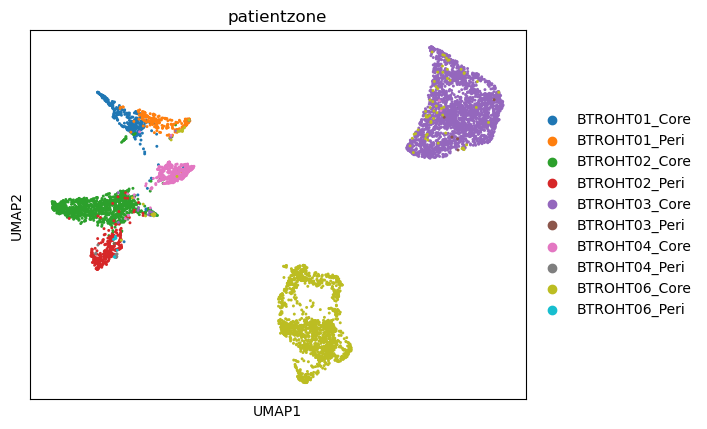

In [9]:
sc.pl.umap(t , color="patientzone")

# with harmony 

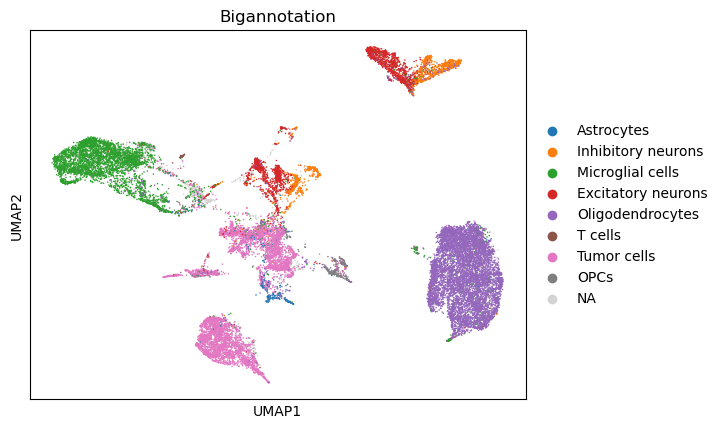

In [50]:
sc.pl.umap(data , color="Bigannotation")

# with CNNCorect 

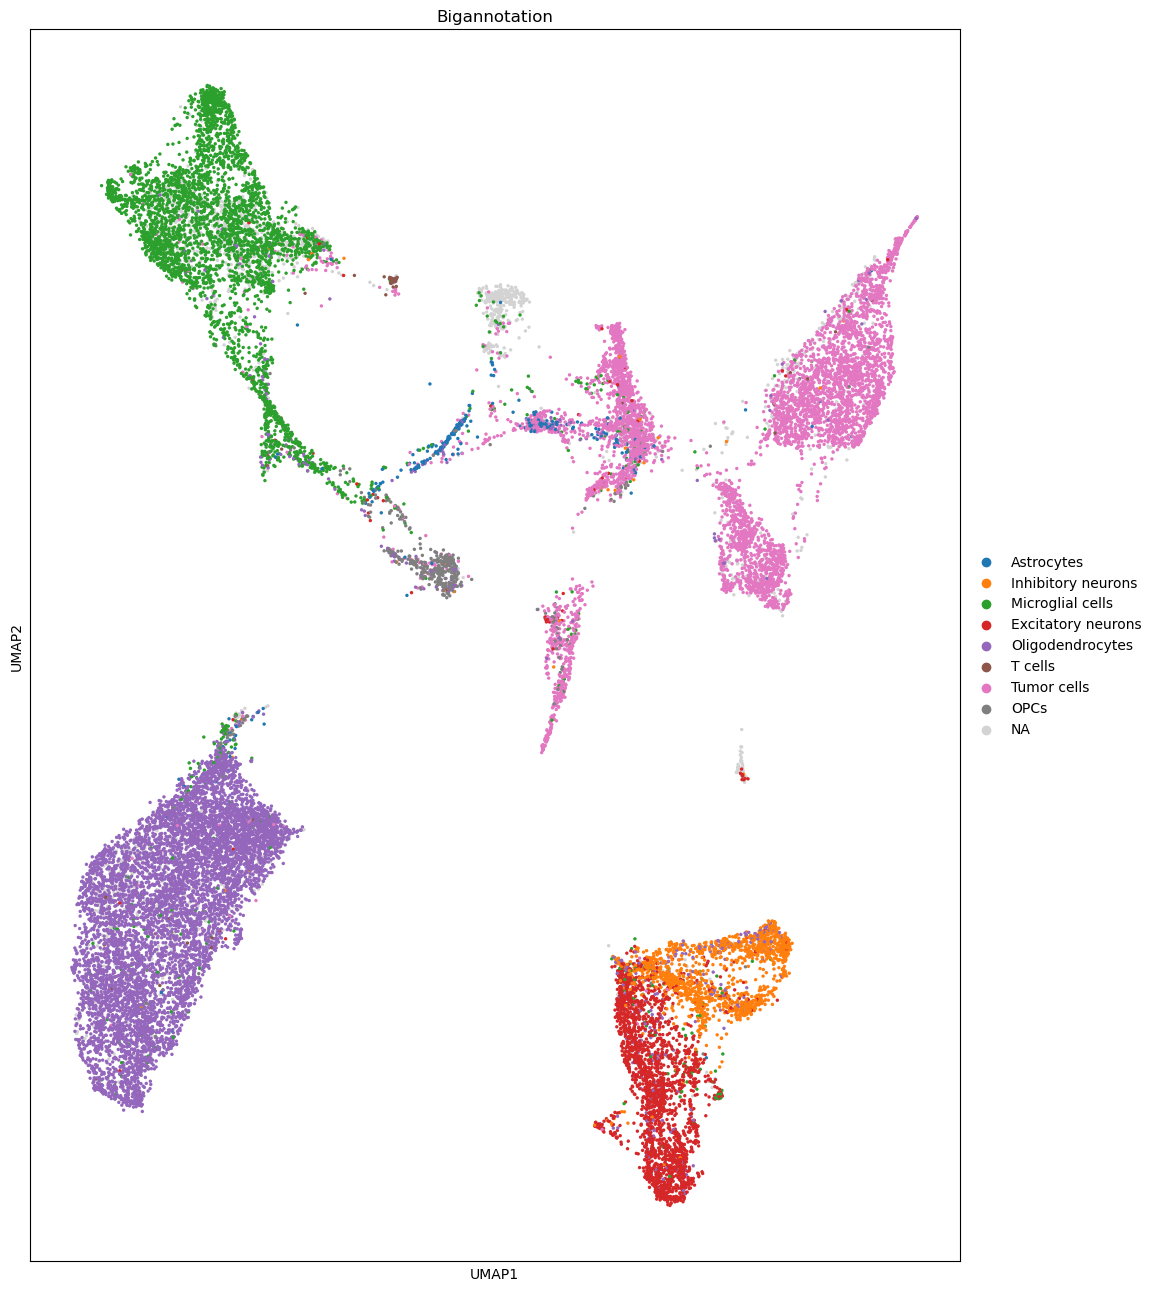

<Figure size 640x480 with 0 Axes>

In [54]:
import scanpy as sc
import matplotlib.pyplot as plt

# Create the UMAP plot
fig, ax = plt.subplots(figsize=(12, 16))  # Create a figure with specific size
sc.pl.umap(data, color="Bigannotation", size=24, frameon=True, ax=ax)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# The dataset was aggregated, and the final UMAP was generated after batch correction with MNNCorrect.


# -- > Next : ATAC visualization (New Notebook)  

In [1]:
!pwd

/home/fatemeh.nasrabadi
